# Project 02 - Image Processing

## Thông tin sinh viên

- Họ và tên: Nguyễn Thọ Tài
- MSSV: 23127255
- Lớp: 23CLC02

## Import các thư viện liên quan

In [ ]:
!python -m pip install matplotlib
!python -m pip install numpy
!python -m pip install Pillow

from PIL import Image # for read, write image
import numpy as np # for matrix compute
import matplotlib.pyplot as plt # for show image
import colorsys # for convert RGB to HSL

## Helper functions

In [73]:
# Any optional parameters beyond the required ones should be defined with default values
def get_base_name(path: str) -> str:
	""" Get the base name of a file
	"""
	p = max(path.rfind('/'), path.rfind('\\'))
	return path[p + 1:] if p != -1 else path

def get_file_name(path: str) -> str:
	dot = path.rfind('.')
	slash = max(path.rfind('/'), path.rfind('\\'))
	return path[:dot] if dot != -1 and dot > slash else path

def get_file_name_without_extension(path: str) -> str:
	return path.rstrip('/\\').split('/')[-1].split('.')[0]

def get_folder_path(path: str) -> str:
	return path[:max(path.rfind('/'), path.rfind('\\')) + 1]

def get_extension(path: str) -> str:
	p = path.rfind('.')
	if p == -1 or p == 0 or '/' in path[p:]:
		return ''
	return path[p + 1:]

def is_valid_extension(path: str) -> bool:
	ext = get_extension(path)
	return ext in ['png', 'jpg', 'jpeg']

def read_img(img_path) -> np.array:
	""" Read image from img_path
	returns a 2D image (numpy array) or None if path doesn't exist
	"""
	if not is_valid_extension(img_path):
		raise ValueError(f"Unsupported file extension: '{get_extension(img_path)}'")
	raw_img = Image.open(img_path)
	if raw_img is None:
		return ValueError(f"File '{img_path}' doesn't exist")
	return np.array(raw_img.convert('RGB')) #.astype(np.float32)

def show_img(img_2d):
	""" Show image
	"""
	plt.imshow(img_2d.astype(np.uint8))
	plt.axis('off')
	plt.show()

def save_img(img_2d, img_path: str):
	"""	Save image to img_path
	"""
	ext = get_extension(img_path)
	if ext not in ['png', 'jpg', 'jpeg']:
		raise ValueError(f"Unsupported file extension: '{ext}'")
	if img_2d.dtype != np.uint8:
		img_2d = img_2d.astype(np.uint8) # casting the arr to uint8 if they ain't
	Image.fromarray(img_2d).save(img_path) # exception: OSError

def convert_rgb_to_hsl(img_2d: np.array) -> np.array:
	""" Convert RGB image to HSL image
	returns a 2D image (numpy array)
	"""
	norm_img = img_2d / 255.0
	rgb2hsl_vec = np.vectorize(colorsys.rgb_to_hls)
	h, l, s = rgb2hsl_vec(norm_img[..., 0], norm_img[..., 1], norm_img[..., 2]) # img[..., 0] means take all previous dim but only the 0 index of the last one. (4, 4, 3) -> (4, 3)
	return np.dstack([h, s, l]) # hsl

def convert_hsl_to_rgb(img_2d: np.array) -> np.array:
	""" Convert HSL image to RGB image
	returns a 2D image (numpy array)
	"""
	hsl2rgb_vec = np.vectorize(colorsys.hls_to_rgb)
	r, g, b = hsl2rgb_vec(img_2d[..., 0], img_2d[..., 1], img_2d[..., 2])
	if img_2d.ndim == 4:
		return np.dstack([r, g, b, img_2d[..., 3]] * 255).astype(np.uint8) # rgba
	return (np.dstack([r, g, b]) * 255).astype(np.uint8) # rgb

# 1. Change the image brightness
def img_change_brightness(img_2d: np.array, value: int) -> np.array:
	img_2d = img_2d.astype(np.float32)
	img_2d += value
	return np.clip(img_2d, 0, 255).astype(np.uint8)

# 2. Change the image contrast
def img_change_contrast(img_2d: np.array, factor: float) -> np.array:
	img_2d = img_2d.astype(np.float32)
	img_2d -= 127.0  # map the range from (0,256) to (-127, 128) with dark parts being lower than 0 and the opposite for light part
	img_2d *= factor # distance the dark and light part by factor amount
	img_2d += 127.0  # remap it back to normal range (0, 256)
	np.clip(img_2d, 0, 255, out=img_2d) # clip out overflowed value
	return img_2d.astype(np.uint8)

"""
Convert to grayscale (rec601, rec709)

Ref:
- Wikipedia, Rec.601 luma versus Rec.709 luma coefficients,
Accessed 17 July 2025, https://en.wikipedia.org/wiki/Luma_(video)#Rec._601_luma_versus_Rec._709_luma_coefficients
- OpenCV, CvtColor - Miscellaneous transformations
Accessed 20 July 2025, https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cvtcolor
"""
# 4. RGB to grayscale
def img_to_grayscale(img_2d: np.array, mode: str = 'rec709') -> np.array:
	if mode == 'rec709':
		# rec709: l = 0.2126 * r + 0.7152 * g + 0.0722 * b
		luma = 0.2126 * img_2d[:, :, 0] + 0.7152 * img_2d[:, :, 1] + 0.0722 * img_2d[:, :, 2]
	elif mode == 'rec601':
		# rec601: l = 0.2989 * r + 0.587 * g + 0.114 * b
		luma = 0.2989 * img_2d[:, :, 0] + 0.587 * img_2d[:, :, 1] + 0.114 * img_2d[:, :, 2]
	else:
		return img_2d # return raw image
	result = np.zeros_like(img_2d, dtype=np.uint8) # initialize an empty result array
	result[:, :, 0] = result[:, :, 1] = result[:, :, 2] = luma
	return result

# def img_to_grayscale_direct(img_2d: np.array, mode: str = 'rec709'):
# 	if mode == 'rec709':
# 		# rec709: l = 0.2126 * r + 0.7152 * g + 0.0722 * b
# 		luma = 0.2126 * img_2d[:, :, 0] + 0.7152 * img_2d[:, :, 1] + 0.0722 * img_2d[:, :, 2]
# 	elif mode == 'rec601':
# 		# rec601: l = 0.2989 * r + 0.587 * g + 0.114 * b
# 		luma = 0.2989 * img_2d[:, :, 0] + 0.587 * img_2d[:, :, 1] + 0.114 * img_2d[:, :, 2]
# 	else:
# 		return
# 	img_2d[:, :, 0] = img_2d[:, :, 1] = img_2d[:, :, 2] = luma

"""
Applies a sepia effect.

Ref:
- Stack Overflow, Processing an image to sepia tone in Python
Accessed 24 July 2025, https://stackoverflow.com/q/36434905
"""
# 4. RGB to sepia tone
def img_to_sepia(img_2d: np.array) -> np.array:
	img_2d = img_2d.astype(np.float32)
	sepia_filter = np.array([
		[0.393, 0.769, 0.189],
		[0.349, 0.686, 0.168],
		[0.272, 0.534, 0.131]
	], dtype=np.float32)
	# apply the sepia filter to each pixel using matrix mul
	img_2d = np.clip(np.dot(img_2d, sepia_filter.T), 0, 255)
	return img_2d.astype(np.uint8)

def img_flip_horizontal(img_2d: np.array) -> np.array:
	return img_2d[:, ::-1]

def img_flip_vertical(img_2d: np.array) -> np.array:
	return img_2d[::-1, :]

def img_flip_horizontal_vertical(img_2d: np.array) -> np.array:
	return img_2d[::-1, ::-1]

# 3. Image flip
def img_flip(img_2d: np.array, mode: str ='horizontal') -> np.array:
	if mode == 'horizontal':
		print("Caslign")
		return img_flip_horizontal(img_2d)
	if mode == 'vertical':
		return img_flip_vertical(img_2d)
	if mode == 'both':
		return img_flip_horizontal_vertical(img_2d)
	return img_2d

def img_crop(img_2d: np.array, start: list[int], end: list[int]) -> np.array:
	height, width, _ = img_2d.shape
	x1, x2 = sorted([max(0, min(start[0], width)), max(0, min(end[0], width))])
	y1, y2 = sorted([max(0, min(start[1], height)), max(0, min(end[1], height))])
	return img_2d[y1:y2, x1:x2, :].astype(np.uint8)

# 6. Crop a quarter at the center of the image
def img_crop_quarter_center(img_2d: np.array) -> np.array:
	height, width, _ = img_2d.shape
	start_height, start_width = height // 4, width // 4
	return img_crop(img_2d, [start_width, start_height], [start_width * 3, start_height * 3])

"""
Using np.ogrid to mask the image

Ref:
https://medium.com/data-science/the-little-known-ogrid-function-in-numpy-19ead3bdae40
"""
def img_circle_mask(img_2d: np.array) -> np.array:
	masked_img = img_2d.copy()
	height, width, _ = img_2d.shape
	y, x = np.ogrid[:height, :width]
	cy, cx = height // 2, width // 2
	r = min(cx, cy)
	mask = (x - cx) ** 2 + (y - cy) ** 2 <= r ** 2
	masked_img[~mask] = np.zeros((height, width, 3), np.uint8)[~mask]
	return masked_img

def img_circle_mask(img_2d: np.array) -> np.array:
	h, w, _ = img_2d.shape
	cy, cx = h // 2, w // 2
	r = min(cx, cy)
	y, x = np.ogrid[:h, :w]
	mask = (x - cx) ** 2 + (y - cy) ** 2 <= r ** 2
	masked_img = np.zeros_like(img_2d)
	masked_img[mask] = img_2d[mask]
	return masked_img

def rotated_ellipse_mask(x, y, a, b, theta):
	cos_t, sin_t = np.cos(theta), np.sin(theta)
	term1 = ((x * cos_t + y * sin_t) ** 2) / a ** 2
	term2 = ((x * sin_t - y * cos_t) ** 2) / b ** 2
	return (term1 + term2) <= 1 # x^2 / a^2 + y^2 / b^2 <= 1, take the inner part

def img_2ellipse_mask(img_2d: np.ndarray) -> np.array:
	masked_img = img_2d.copy()
	height, width, _ = img_2d.shape
	diag = 1.4142 * min(height, width) - 5
	# a = (7 / 8) * diag / 2, b = 0.5 * diag / 2
	a, b = 0.4375 * diag, 0.25 * diag
	theta = np.pi / 4
	y, x = np.ogrid[:height, :width]
	# translate the grid coord to the center of the shape
	y -= height // 2
	x -= width // 2

	mask = np.logical_or(rotated_ellipse_mask(x, y, a, b, theta), rotated_ellipse_mask(x, y, a, b, -theta))
	masked_img[mask] = np.zeros_like(img_2d)[mask]
	return masked_img

# 7. Crop image by frame
def img_mask(img_2d: np.array, mode: str = 'circle') -> np.array:
	"""

	"""
	if mode == 'circle':
		return img_circle_mask(img_2d)
	if mode == 'ellipse':
		return img_2ellipse_mask(img_2d)
	return img_2d

def kernel_identity(size: int) -> np.array:
	return np.pad([[1]], pad_width=size//2)

def kernel_box_blur(size: int) -> np.ndarray:
	return np.ones((size, size)) / size ** 2

def kernel_gauss_blur(size: int) -> np.ndarray:
	if size % 2 == 0 or size < 1:
		raise ValueError("Size must be odd and positive")
	kernel_1d = np.array([1, 1])
	for _ in range(size - 2):
		kernel_1d = np.convolve(kernel_1d, [1, 1])
	return np.outer(kernel_1d, kernel_1d) / (4 ** (size - 1))

MAT_BOX_BLUR_3 = kernel_box_blur(3)
MAT_BOX_BLUR_5 = kernel_box_blur(5)
MAT_BOX_BLUR_7 = kernel_box_blur(7)
MAT_BOX_BLUR_15 = kernel_box_blur(15)

MAT_GAUSS_BLUR_3 = 0.0625 * np.array(
	[[1, 2, 1],
	 [2, 4, 2],
	 [1, 2, 1]])

MAT_GAUSS_BLUR_5 = 0.00390625 * np.array(
	[[1,  4,  6,  4,  1],
	 [4, 16, 24, 16, 14],
	 [6, 24, 36, 24,  6],
	 [4, 16, 24, 16,  4],
	 [1,  4,  6,  4,  1]])

MAT_GAUSS_BLUR_7 = kernel_gauss_blur(7)
MAT_GAUSS_BLUR_15 = kernel_gauss_blur(15)
MAT_GAUSS_BLUR_21 = kernel_gauss_blur(21)

MAT_UNSHARP_BLUR_5 = -0.00390625 * np.array(
	[[1,  4,    6,  4,  1],
	 [4, 16,   24, 16, 14],
	 [6, 24, -476, 24,  6],
	 [4, 16,   24, 16,  4],
	 [1,  4,    6,  4,  1]])

# detailed doc in the report
def kernel_convolution_stride(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')

	norm_img = img_2d.astype(np.float16) / 255.0
	height, width, _ = norm_img.shape
	k_height, k_width = kernel.shape
	if k_height != k_width:
		raise ValueError('Input kernel matrix must be square')

	# pad image to handle boundaries
	pad_size = k_height // 2
	pad_img = np.pad(norm_img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')

	patches = np.lib.stride_tricks.sliding_window_view(pad_img, window_shape=(k_height, k_height), axis=(0, 1)) # shape: (height, width, channel, k_height, k_width)
	result = np.einsum('abcde,de->abc', patches, kernel)
	result = np.clip(result * 255, 0, 255).astype(np.uint8)
	return result

# We have that F(a * b) = F(a) * F(b) -> A * B = IF(a) * IF(b)
# By this hacky method, we utilize the fft for us to quick calculate the convoluted image
# More deteail in the reports
# Ref: https://www.geeksforgeeks.org/data-science/how-to-perform-faster-convolutions-using-fast-fourier-transformfft-in-python/
def kernel_convolution_rfft(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')
	norm_img = img_2d.astype(np.float32) / 255.0
	h, w, c = norm_img.shape
	if kernel.shape[0] != kernel.shape[1]:
		raise ValueError('Kernel must be square')

	k = kernel.shape[0]
	pad = k // 2
	padded_img = np.pad(norm_img, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
	fft_h = padded_img.shape[0] + k - 1
	fft_w = padded_img.shape[1] + k - 1
	kernel_fft = np.fft.rfft2(kernel.astype(np.float32), s=(fft_h, fft_w))
	result = np.empty((h, w, c), dtype=np.float32)
	r0, r1 = k - 1, padded_img.shape[0]
	c0, c1 = k - 1, padded_img.shape[1]
	for i in range(c):
		channel_fft = np.fft.rfft2(padded_img[:, :, i], s=(fft_h, fft_w))
		conv_fft = channel_fft * kernel_fft
		conv_real = np.fft.irfft2(conv_fft, s=(fft_h, fft_w))
		result[:, :, i] = conv_real[r0:r1, c0:c1]
	return np.clip(result * 255.0, 0, 255).astype(np.uint8)

# from O(n^2) to O(2n). This save both memory and time, by calling np.apply_along_axis: we do the same convolution in one axe of the kernel than the other
def kernel_seperate_convolution(img: np.ndarray, kernel_1d: np.ndarray) -> np.ndarray:
	if img.ndim != 3:
		raise ValueError("Image must be 3D (H, W, C)")
	if kernel_1d.ndim != 1:
		raise ValueError("Kernel must be 1D")
	h, w, c = img.shape
	img = np.pad(img.astype(np.float32) / 255.0, ((kernel_1d.size // 2, kernel_1d.size // 2), (kernel_1d.size // 2, kernel_1d.size // 2), (0, 0)), mode='reflect')

	for i in range(c):
		img[:h, :, i] = np.apply_along_axis(lambda x: np.convolve(x, kernel_1d, mode='valid'), axis=0, arr=img[:, :, i])
		img[:h, :w, i] = np.apply_along_axis(lambda x: np.convolve(x, kernel_1d, mode='valid'), axis=1, arr=img[:h, :, i])

	return np.clip(img[:h,:w,:] * 255.0, 0, 255).astype(np.uint8)

def kernel_convolution_stride(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')

	norm_img = img_2d.astype(np.float16) / 255.0
	height, width, _ = norm_img.shape
	k_height, k_width = kernel.shape
	if k_height != k_width:
		raise ValueError('Input kernel matrix must be square')

	# pad image to handle boundaries
	pad_size = k_height // 2
	pad_img = np.pad(norm_img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')

	patches = np.lib.stride_tricks.sliding_window_view(pad_img, window_shape=(k_height, k_height), axis=(0, 1)) # shape: (height, width, channel, k_height, k_width)
	result = np.einsum('abcde,de->abc', patches, kernel)
	result = np.clip(result * 255, 0, 255).astype(np.uint8)
	return result

def kernel_convolution(img_2d: np.ndarray, kernel: np.ndarray, mode = 'fft') -> np.ndarray:
	if mode == 'fft':
		if kernel.ndim != 2:
			print('Input kernel must be 2D.')
			return img_2d
		return kernel_convolution_rfft(img_2d, kernel) # 2d kernel
	if mode == 'seperate':
		if kernel.ndim != 1:
			print('Input kernel must be 1D.')
			return img_2d
		return kernel_seperate_convolution(img_2d, kernel) # 1d kernel
	if mode == 'stride':
		if kernel.ndim != 2:
			print('Input kernel must be 2D.')
			return img_2d
		return kernel_convolution_stride(img_2d, kernel)
	print("Invalid mode. Returning original image.")
	return img_2d

# 5. Blur and sharpen the image
def img_blur_sharpen(img_2d: np.ndarray, mode: str = "blur", size: int = 5) -> np.ndarray:
	if size % 2 == 0:
		print("Size must be odd. Skipping.")
		return img_2d
	if mode == "blur":
		return kernel_convolution(img_2d, MAT_GAUSS_BLUR_5 if size == 5 else kernel_gauss_blur(size))
	if mode == "sharpen":
		return kernel_convolution(img_2d, MAT_UNSHARP_BLUR_5)
	return img_2d

def print_help():
	print("Please select of of the following functionality\n"
	"0. Save image (Run all functions)\n"
	"1. Adjust brightness\n"
	"2. Adjust contrast\n"
	"3. Flip image horizontally/vertically\n"
	"4. Convert image to grayscale/sepia\n"
	"5. Blur/sharpen image\n"
	"6. Cut quarter image at the center\n"
	"7. Cut image with circle/ellipse frame\n")

def suffix_save_name(filepath: str, suffix: str, ext: str = None) -> str:
	if ext is None:
		ext = get_extension(filepath)
	return get_file_name_without_extension(filepath) + '_' + suffix + '.' + ext

def process_image(img_2d, func=[1, 2, 3,...], file_name = "", save_file: bool = False) -> np.array:
	""" Process image with a list of functions
	func: a list of functions to apply to the image
	return processed 2D image
	"""
	func_name = ""
	for choice in func:
		if choice == 1:
			# Adjust brightness
			try:
				value = int(input("Enter brightness value [-255, 255]: "))
			except ValueError:
				print("Brightness value must be between [-255, 255]. Defaulting to 100.")
				value = 100
			if value < 0 or value > 255:
				print("Brightness value must be between [-255, 255]. Defaulting to 100.")
				value = 100
			func_name = "brightness"
			img_2d = img_change_brightness(img_2d, value=value)
			print(f"Brightness adjusted by {value} amount.")
		elif choice == 2:
			# Adjust contrast
			try:
				factor = float(input("    Factor > 1 -> increase\n"
									 "0 < Factor < 1 -> decrease\n"
									 "Enter contrast factor between [0, 2], eg: 1.5: "))
			except ValueError:
				print("Contrast factor must be between [0, 2]. Defaulting to 1.5")
				factor = 1.5
			if factor < 0 or factor > 2:
				print("Contrast factor must be between [0, 2]. Defaulting to 1.5")
				factor = 1.5
			func_name = "contrast"
			img_2d = img_change_contrast(img_2d, factor=factor)
			print(f"Contrast adjusted by {factor} amount.")
		elif choice == 3:
			# Flip image
			try:
				flip_mode = input("Enter flip mode (horizontal/vertical/both): ")
			except ValueError:
				print("Flip mode must be either 'horizontal', 'vertical' or 'both'. Defaulting to 'horizontal'")
				fillip_mode = "horizontal"
			if flip_mode not in ("horizontal", "vertical", "both"):
				print("Flip mode must be either 'horizontal', 'vertical' or 'both'. Defaulting to 'horizontal'")
				fillip_mode = "horizontal"
			img_2d = img_flip(img_2d, mode=flip_mode)
			func_name = "flip"
			print(f"Image flipped {flip_mode}.")
		elif choice == 4:
			# Convert image to grayscale or sepia
			color_mode = input("Enter mode (grayscale/sepia): ")
			if color_mode not in ("grayscale", "sepia"):
				print("Mode must be either 'grayscale' or 'sepia'. Defaulting to 'grayscale'")
				color_mode = "grayscale"
			if color_mode == 'grayscale':
				func_name = "grayscale"
				mode = input("Enter grayscale mode (rec601: old/rec709: newer): ")
				if mode not in ('rect601', 'rec709'):
					print("Mode must be either 'rect601', 'rec709'. Defaulting to 'rec709'")
					mode = 'rec709'
				img_2d = img_to_grayscale(img_2d, mode=mode)
				print(f"Image converted to grayscale '{mode}'.")
			elif color_mode == 'sepia':
				func_name = "sepia"
				img_2d = img_to_sepia(img_2d)
				print("Image converted to sepia.")
		elif choice == 5:
			# Blur or sharpen image
			blur_sharpen_mode = input("Enter mode (blur/sharpen): ")
			if blur_sharpen_mode not in ("blur", "sharpen"):
				print("Mode must be either 'blur', 'sharpen'. Defaulting to 'blur'.")
				blur_sharpen_mode = "blur"
			func_name = blur_sharpen_mode
			img_2d = img_blur_sharpen(img_2d, mode=blur_sharpen_mode)
			print(f"Image {blur_sharpen_mode} applied.")
		elif choice == 6:
			# Cut quarter image at the center
			img_2d = img_crop_quarter_center(img_2d)
			func_name = "crop"
			print("Quarter of the image at the center cropped.")
		elif choice == 7:
			# Cut image with circle/ellipse frame
			frame_mode = input("Enter frame mode (circle/ellipse): ")
			if frame_mode not in ['circle', 'ellipse']:
				print("Invalid mode. Defaulting to 'circle'.")
				frame_mode = "circle"
			func_name = "frame_" + frame_mode
			img_2d = img_mask(img_2d, mode=frame_mode)
			print(f"Image masked with {frame_mode} frame.")
		else:
			print(f"Invalid option. Skipping this functionality {choice}.")
			continue
		if save_file:
			output_path = suffix_save_name(file_name, suffix=func_name, ext='png')
			print("Saving image to", output_path)
			save_img(img_2d, output_path)
		show_img(img_2d)


## Your tests

In [ ]:
import os
import tracemalloc
import time
import sys

def test_flip():
	folder = "image/flip/"
	os.makedirs("image/flip/", exist_ok=True)
	img = read_img("cat.jpg")
	flip_h_img = img_flip_horizontal(img)
	flip_v_img = img_flip_vertical(img)
	flip_hv_img = img_flip_horizontal_vertical(img)
	save_img(flip_h_img, "image/flip/flip_horizontal_cat.jpg")
	save_img(flip_v_img, "image/flip/flip_vertical_cat.jpg")
	save_img(flip_hv_img, "image/flip/flip_horizontal_vertical_cat.jpg")

def test_mask(file_path: str):
	os.makedirs("image/mask/", exist_ok=True)
	img = read_img(file_path)
	print(img.dtype, img.shape)
	file_name_no_ext = get_file_name_without_extension(file_path)
	circle_masked_img = img_circle_mask(img)
	ellipse_masked_img = img_2ellipse_mask(img)
	get_base_name(file_path)
	save_img(circle_masked_img, f"image/mask/mask_circle_{file_name_no_ext}.jpg")
	save_img(ellipse_masked_img, f"image/mask/mask_ellipse_{file_name_no_ext}.jpg")

def test_color_filter(file_path: str):
	folder = "image/color_filter/"
	os.makedirs(folder, exist_ok=True)
	img = read_img(file_path)
	file_name_no_ext = get_file_name_without_extension(file_path)
	gray_709_img = img_to_grayscale(img, 'rec709')
	gray_601_img = img_to_grayscale(img, 'rec601')
	sepia_img = img_to_sepia(img)
	save_img(gray_601_img, folder + f"grayscale_r601_{file_name_no_ext}.jpg")
	save_img(gray_709_img, folder + f"grayscale_r709_{file_name_no_ext}.jpg")
	save_img(sepia_img, folder + f"sepia_{file_name_no_ext}.jpg")

def test_brightness_contrast(file_path: str, value: int = 50, factor: float = 1.5):
	folder = "image/brightness_contrast/"
	os.makedirs(folder, exist_ok=True)
	img = read_img(file_path)
	file_name_no_ext = get_file_name_without_extension(file_path)
	brightness_img = img_change_brightness(img, value)
	contrast_img = img_change_contrast(img, factor)
	save_img(brightness_img, folder + f"brightness_{value}_{file_name_no_ext}.jpg")
	save_img(contrast_img, folder + f"contrast_{factor}_{file_name_no_ext}.jpg")

def test_crop_image(file_path: str):
	folder = "image/crop_image/"
	os.makedirs(folder, exist_ok=True)
	img = read_img(file_path)
	file_name_no_ext = get_file_name_without_extension(file_path)
	crop_img = img_crop_quarter_center(img)
	save_img(crop_img, folder + f"crop_{file_name_no_ext}.jpg")

orig_stdout = sys.stdout
def file_stdout(file: str):
	sys.stdout = open(file, 'w')

def reset_stdout():
	sys.stdout.close()
	sys.stdout = orig_stdout

test_mask('cat.jpg')
# test_color_filter('cat.jpg')
# test_flip()
# test_brightness_contrast('cat.jpg', -50, 0.5)
# test_crop_image('cat.jpg')

## Main FUNCTION

Confirmed to not save image automatically for choices (1-7).
Please select of of the following functionality
0. Save image (Run all functions)
1. Adjust brightness
2. Adjust contrast
3. Flip image horizontally/vertically
4. Convert image to grayscale/sepia
5. Blur/sharpen image
6. Cut quarter image at the center
7. Cut image with circle/ellipse frame

Running all functions...
Brightness value must be between [-255, 255]. Defaulting to 100.
Brightness adjusted by 100 amount.
Saving image to nature_brightness.png


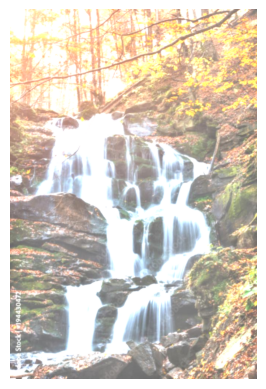

Contrast factor must be between [0, 2]. Defaulting to 1.5
Contrast adjusted by 1.5 amount.
Saving image to nature_contrast.png


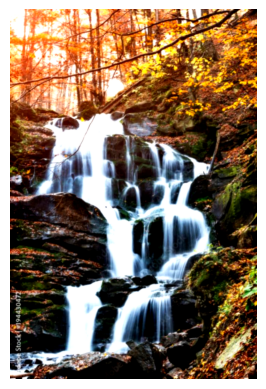

Flip mode must be either 'horizontal', 'vertical' or 'both'. Defaulting to 'horizontal'
Image flipped .
Saving image to nature_flip.png


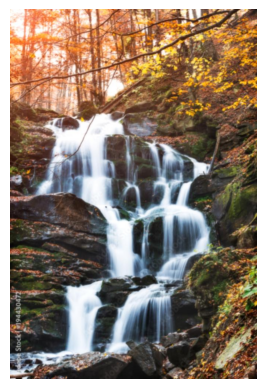

Mode must be either 'grayscale' or 'sepia'. Defaulting to 'grayscale'
Mode must be either 'rect601', 'rec709'. Defaulting to 'rec709'
Image converted to grayscale 'rec709'.
Saving image to nature_grayscale.png


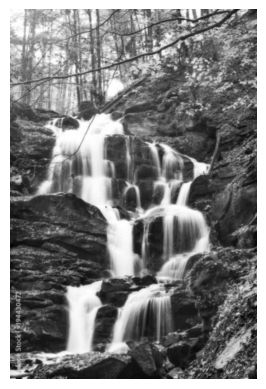

Mode must be either 'blur', 'sharpen'. Defaulting to 'blur'.
Image blur applied.
Saving image to nature_blur.png


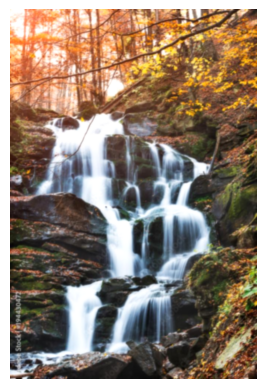

Quarter of the image at the center cropped.
Saving image to nature_crop.png


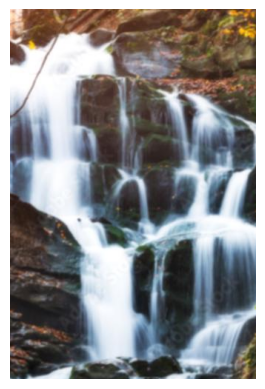

Invalid mode. Defaulting to 'circle'.
Image masked with circle frame.
Saving image to nature_frame_circle.png


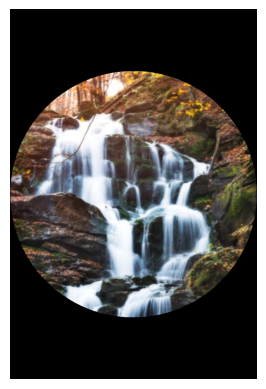

In [76]:
def main():
	img_path = str(input("Path to the image (only jpg, jpeg, png): "))
	try:
		img = read_img(img_path)
	except Exception as e:
		print(f"Error: {e}")
		return
	save_file_cfg = input("Do you want to save image automatically for choices (1-7)? (y/n): ")
	do_save = False
	if save_file_cfg == "y":
		print("Confirmed to save image automatically for choices (1-7).")
		do_save = True
	elif save_file_cfg == "n":
		print("Confirmed to not save image automatically for choices (1-7).")
		do_save = False
	else:
		print("Unknown input - default to no.")
	file_name_no_ext = get_file_name_without_extension(img_path)
	print_help()
	try:
		input_str = input("Enter your choice (squence separated by space): ")
		choices = input_str.split()
		if len(choices) == 1 and int(choices[0]) == 0:
			print("Running all functions...")
			for i in range(7):
				process_image(img, [i + 1], img_path, save_file=True)
			return
		if all(choice.isdigit() and 0 < int(choice) < 8 for choice in choices):
			print("Running choices: " + str(choices))
			numbers = [int(choice) for choice in choices]
			process_image(img, numbers, img_path, save_file=do_save)
		else:
			print("Invalid input: all choices must be numbers from 1 to 7 or 0.")
	except ValueError:
		print("Invalid input. Please enter a valid inputs.")
main()
